# **Twitter Abuse Detection**
---

### **IMPORTING DEPENDENCIES AND DATASET**

---



In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import random

In [19]:
#!pip -q install langchain huggingface_hub transformers sentence_transformers

In [20]:
df = pd.read_csv("labeled_data.csv")
df.drop(columns=["Unnamed: 0","count","hate_speech","offensive_language","neither"],axis=1,inplace=True)
df['predicted_column'] = ""

In [21]:
df1 = df.copy()

In [22]:
df1['class'] = df1['class'].map({
    0: 'Hate',
    1: 'Abusive',
    2: 'Neutral'
})

In [23]:
df

,class,tweet,predicted_column
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,
24779,2,"you've gone and broke the wrong heart baby, an...",
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,
24781,1,youu got wild bitches tellin you lies,


In [24]:
# Data preprocessing
tweet = df1['tweet'].tolist()
true_label = df1['class'].tolist()

In [25]:
sample_size = 3000 
sample_indices = random.sample(range(len(df)), sample_size)

# **Transformer Embeddings**

In [26]:
#!pip install transformers
# A dependency of the preprocessing for BERT inputs
#!pip install -q tensorflow-text
!pip install -q tf-models-official

In [27]:
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.10.1


In [28]:
df0 = df.copy()
c=df0['class']
df0.rename(columns={'tweet' : 'text','class' : 'category'},inplace=True)

In [29]:
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

In [30]:
df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'},inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [31]:
df.groupby('label').count()

,text,category
label,,
0,1430,1430
1,19190,19190
2,4163,4163


In [32]:
!pip install WordCloud STOPWORDS

<class 'set'>


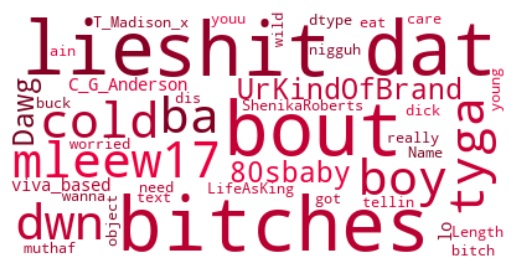

In [33]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="offensive_language"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

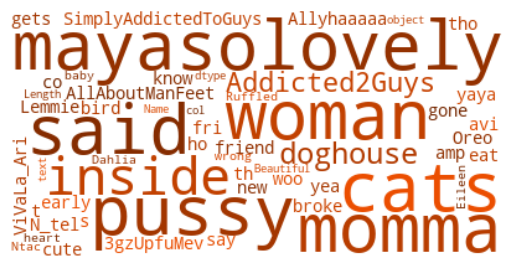

In [34]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="neither"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


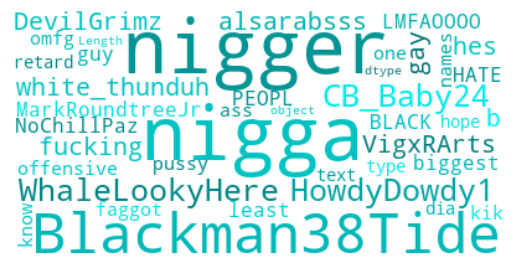

In [35]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="hate_speech"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


In [36]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [37]:
pipe = pipeline("text-classification", model="igmarco/clasificador-hate_speech_offensive")

loading configuration file config.json from cache at C:\Users\aksha/.cache\huggingface\hub\models--igmarco--clasificador-hate_speech_offensive\snapshots\e73a8f19eb0633f02c898328f48c1a668d92837e\config.json
Model config BertConfig {
  "_name_or_path": "igmarco/clasificador-hate_speech_offensive",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification

In [38]:
custom_class_mapping = {
    0: "Hate",
    1: "Abusive",
    2: "Neutral",
}

In [39]:
for class_id, new_label in custom_class_mapping.items():
    pipe.model.config.id2label[class_id] = new_label

In [40]:
updated_output_classes = pipe.model.config.id2label
print(updated_output_classes)

{0: 'Hate', 1: 'Abusive', 2: 'Neutral'}


In [41]:
correctly_classified = 0
incorrectly_classified = 0

true_labels = []  # To store true labels
predicted_labels = []  # To store predicted labels

In [ ]:
for row_num in sample_indices:
    row = df1.loc[row_num]
    text = row['tweet']
    true_label = row['class']

    # Use the model to make predictions
    predicted_label = pipe(text)[0]["label"]

    # Update the predicted_label in the dataframe
    df1.at[row_num, 'predicted_column'] = predicted_label

    # Store true and predicted labels for later analysis
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    print(f"Row {row_num} - True Label: {true_label}, Predicted Label: {predicted_label}")

    # Check if the prediction is correct
    if true_label == predicted_label:
        correctly_classified += 1
    else:
        incorrectly_classified += 1

# Print the total correct and incorrect classifications
print(f"Correctly classified: {correctly_classified}")
print(f"Incorrectly classified: {incorrectly_classified}")

Row 1812 - True Label: Abusive, Predicted Label: Abusive
Row 23853 - True Label: Abusive, Predicted Label: Abusive
Row 6967 - True Label: Abusive, Predicted Label: Abusive
Row 22941 - True Label: Abusive, Predicted Label: Abusive
Row 7179 - True Label: Abusive, Predicted Label: Abusive
Row 15824 - True Label: Abusive, Predicted Label: Abusive
Row 9391 - True Label: Abusive, Predicted Label: Abusive
Row 21565 - True Label: Abusive, Predicted Label: Abusive
Row 14256 - True Label: Abusive, Predicted Label: Abusive
Row 17787 - True Label: Hate, Predicted Label: Hate
Row 11161 - True Label: Neutral, Predicted Label: Neutral
Row 5804 - True Label: Abusive, Predicted Label: Abusive
Row 23407 - True Label: Abusive, Predicted Label: Abusive
Row 2554 - True Label: Abusive, Predicted Label: Abusive
Row 993 - True Label: Abusive, Predicted Label: Abusive
Row 11727 - True Label: Abusive, Predicted Label: Abusive
Row 18660 - True Label: Abusive, Predicted Label: Abusive
Row 22763 - True Label: Abus

Row 5110 - True Label: Neutral, Predicted Label: Neutral
Row 4074 - True Label: Abusive, Predicted Label: Abusive
Row 494 - True Label: Neutral, Predicted Label: Neutral
Row 1426 - True Label: Abusive, Predicted Label: Abusive
Row 17741 - True Label: Abusive, Predicted Label: Abusive
Row 21282 - True Label: Abusive, Predicted Label: Abusive
Row 12429 - True Label: Abusive, Predicted Label: Abusive
Row 2379 - True Label: Abusive, Predicted Label: Abusive
Row 12715 - True Label: Neutral, Predicted Label: Neutral
Row 24034 - True Label: Abusive, Predicted Label: Abusive
Row 15157 - True Label: Abusive, Predicted Label: Abusive
Row 21611 - True Label: Hate, Predicted Label: Hate
Row 22729 - True Label: Abusive, Predicted Label: Abusive
Row 8215 - True Label: Abusive, Predicted Label: Abusive
Row 3912 - True Label: Hate, Predicted Label: Abusive
Row 8260 - True Label: Abusive, Predicted Label: Abusive
Row 14698 - True Label: Abusive, Predicted Label: Abusive
Row 9822 - True Label: Abusive, 

Row 41 - True Label: Abusive, Predicted Label: Abusive
Row 2414 - True Label: Abusive, Predicted Label: Abusive
Row 9665 - True Label: Abusive, Predicted Label: Abusive
Row 19387 - True Label: Abusive, Predicted Label: Abusive
Row 20425 - True Label: Abusive, Predicted Label: Abusive
Row 10383 - True Label: Abusive, Predicted Label: Abusive
Row 450 - True Label: Abusive, Predicted Label: Abusive
Row 15380 - True Label: Abusive, Predicted Label: Abusive
Row 4152 - True Label: Abusive, Predicted Label: Abusive
Row 23748 - True Label: Abusive, Predicted Label: Abusive
Row 9325 - True Label: Abusive, Predicted Label: Abusive
Row 19560 - True Label: Abusive, Predicted Label: Abusive
Row 15415 - True Label: Abusive, Predicted Label: Abusive
Row 17749 - True Label: Abusive, Predicted Label: Abusive
Row 6806 - True Label: Neutral, Predicted Label: Neutral
Row 9944 - True Label: Abusive, Predicted Label: Abusive
Row 2917 - True Label: Abusive, Predicted Label: Abusive
Row 10627 - True Label: Ab

Row 10078 - True Label: Abusive, Predicted Label: Abusive
Row 14731 - True Label: Neutral, Predicted Label: Abusive
Row 10630 - True Label: Neutral, Predicted Label: Neutral
Row 17717 - True Label: Abusive, Predicted Label: Abusive
Row 21359 - True Label: Abusive, Predicted Label: Abusive
Row 10772 - True Label: Neutral, Predicted Label: Neutral
Row 11965 - True Label: Abusive, Predicted Label: Abusive
Row 23151 - True Label: Abusive, Predicted Label: Abusive
Row 3681 - True Label: Abusive, Predicted Label: Abusive
Row 19179 - True Label: Abusive, Predicted Label: Abusive
Row 14896 - True Label: Abusive, Predicted Label: Abusive
Row 15874 - True Label: Neutral, Predicted Label: Neutral
Row 13371 - True Label: Abusive, Predicted Label: Hate
Row 12602 - True Label: Abusive, Predicted Label: Abusive
Row 9315 - True Label: Abusive, Predicted Label: Abusive
Row 17454 - True Label: Abusive, Predicted Label: Abusive
Row 10602 - True Label: Abusive, Predicted Label: Abusive
Row 4294 - True Lab

Row 22229 - True Label: Abusive, Predicted Label: Abusive
Row 7482 - True Label: Abusive, Predicted Label: Abusive
Row 22403 - True Label: Abusive, Predicted Label: Abusive
Row 16475 - True Label: Neutral, Predicted Label: Neutral
Row 3607 - True Label: Abusive, Predicted Label: Abusive
Row 10098 - True Label: Neutral, Predicted Label: Neutral
Row 8748 - True Label: Neutral, Predicted Label: Abusive
Row 2750 - True Label: Abusive, Predicted Label: Abusive
Row 24357 - True Label: Abusive, Predicted Label: Abusive
Row 12523 - True Label: Abusive, Predicted Label: Abusive
Row 3641 - True Label: Abusive, Predicted Label: Abusive
Row 22327 - True Label: Abusive, Predicted Label: Abusive
Row 10228 - True Label: Abusive, Predicted Label: Abusive
Row 24500 - True Label: Abusive, Predicted Label: Abusive
Row 5516 - True Label: Abusive, Predicted Label: Abusive
Row 16317 - True Label: Neutral, Predicted Label: Neutral
Row 20782 - True Label: Abusive, Predicted Label: Abusive
Row 19096 - True Lab

Row 15865 - True Label: Abusive, Predicted Label: Abusive
Row 2694 - True Label: Abusive, Predicted Label: Abusive
Row 12534 - True Label: Abusive, Predicted Label: Abusive
Row 10358 - True Label: Abusive, Predicted Label: Abusive
Row 5660 - True Label: Abusive, Predicted Label: Abusive
Row 14985 - True Label: Hate, Predicted Label: Hate
Row 12431 - True Label: Abusive, Predicted Label: Abusive
Row 12890 - True Label: Abusive, Predicted Label: Abusive
Row 10254 - True Label: Neutral, Predicted Label: Neutral
Row 10111 - True Label: Abusive, Predicted Label: Abusive
Row 2894 - True Label: Abusive, Predicted Label: Abusive
Row 8130 - True Label: Abusive, Predicted Label: Neutral
Row 2183 - True Label: Neutral, Predicted Label: Neutral
Row 22641 - True Label: Hate, Predicted Label: Hate
Row 24448 - True Label: Abusive, Predicted Label: Abusive
Row 7060 - True Label: Neutral, Predicted Label: Neutral
Row 12351 - True Label: Abusive, Predicted Label: Abusive
Row 21026 - True Label: Abusive,

In [ ]:
# Calculate and print the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Generate and print the classification report
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

# Generate and print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_mat)